In [1]:
from tqdm import tqdm
from D3QNAgent import Agent
from kaggle_environments import evaluate, make, utils
import numpy as np
from IPython.display import clear_output
import matplotlib.pyplot as plt

env = make("connectx", debug=True)
env.render()

nstep_lookahead_agent = './fast_Nstep_lookahead_agent.py'
random_agent = 'random'
negamax_agent = 'negamax'

Loading environment football failed: No module named 'gfootball'


In [2]:
def live_plot(rewards, i,  eps, j=0):
    if len(rewards) < 100:
        return
        
    clear_output(wait=True)
    fig, (ax1, ax2) = plt.subplots(ncols=2, dpi=120, figsize=(12.8, 3.6))
    ax1.plot(np.array(rewards[100:]), color='orange', linestyle='-')
    # ax1.legend(loc='lower right')
    ax1.set_ylabel('reward')
    ax1.set_xlabel('episode')
    ax1.title.set_text('Agent Total Rewards with Moving Average 100 Episodes')

    plt.show()

    print('episode', i, 
        '\tround', j,
        # '\ttotal rewards %.1f' % tot_reward, 
        # '\taverage rewards %.3f' % avg_rewards[i], 
        # '\tresult ', reward, 
        # '\twin/loss ratio %.3f' % wl_ratio[i], 
        '\tepsilon %.3f' % eps)


In [3]:
def preprocess_board_state(observation):
    board = np.array(observation['board'], dtype=np.float32).reshape(6, 7)
    marker = observation.mark

    state = np.zeros((6, 7, 2), dtype=np.float32)
    
    if marker == 1:
        state[:, :, 0][board == 1] = 1
        state[:, :, 1][board == 2] = 1
        
    else:
        state[:, :, 0][board == 2] = 1
        state[:, :, 1][board == 1] = 1

    return state

In [4]:
agent = Agent(
    env.configuration, 
    lr=1e-3, 
    gamma=0.95, 
    batch_size=128,    #### REMEMBER TO CHANGE IT BACK ####
    epsilon=1,        #### REMEMBER TO CHANGE IT BACK ####
    eps_dec=0.999,
    eps_min=0.02,
    buff_size=50_000,
    conv1_filts=16,
    d1_dims=128,
    d2_dims=128,
    replace_target_weight=20,
    input_shape=(None, 6, 7, 2),
)


In [5]:
def playalong_agent(obs, config):
    # define agent
    agent = Agent(config, input_shape=(None, 6, 7, 2), testing=True)
    try:

        agent.load_DQN_weights('./models/self-play-weights.h5')

        # preprocessing of the state
        state = preprocess_board_state(obs)

        return agent.choose_action(state)
    
    except:
        state = obs.board
        mask = [True if state[idx] == 0 else False for idx in range(config.columns)]
        valid_action_space = np.where(mask)[0]
        action = np.random.choice(valid_action_space)
        return action.item()

In [6]:
rewards, avg_rewards= [], []


In [7]:

# None means the agent being trained
trainer = env.train([negamax_agent, None])

In [8]:
agent.load_DQN_weights('./models/random-cnn-5000.h5')

In [9]:
num_episodes = 5000


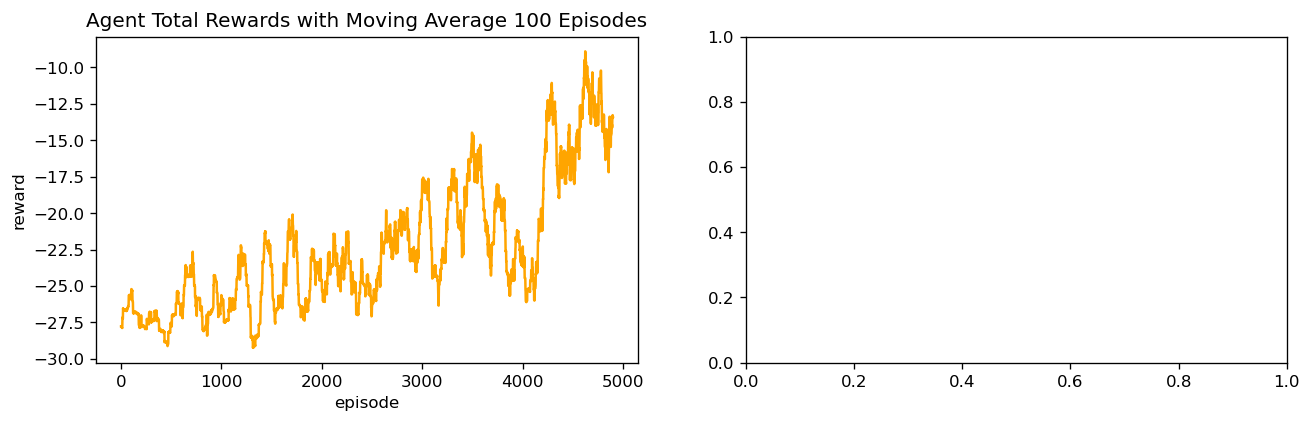

episode 4999 	round 0 	epsilon 0.020


In [10]:
for i in range(num_episodes):
    done = False
    tot_reward = 0

    observation = trainer.reset()
    obs = preprocess_board_state(observation)
    
    # print(obs.reshape(6, 7))

    while not done:

        # choose the best action
        action = agent.choose_action(obs)
        
        # step the environment with action
        # store all returns
        observation_, reward, done, info = trainer.step(action)

        # reprocess the new raw state from the environment
        obs_ = preprocess_board_state(observation_)

        # calculate agent reward from environment response
        agent_reward = agent.get_agent_reward(reward, done)
        
        tot_reward += agent_reward
        
        # store this transition
        agent.update_replay_buffer((obs, action, agent_reward, obs_, done))
        
        # update the current obs with new obs
        obs = obs_
        
        
        agent.learn()
    
    agent.evolve()

    # store total rewards
    rewards.append(tot_reward)
    # store average rewards
    avg_rewards.append(np.mean(rewards[-100:]))
    
    
    if i % 20 == 0:
        live_plot(avg_rewards, i, agent.epsilon)
    

live_plot(avg_rewards, i, agent.epsilon)
agent.save_DQN_weights('./models/cnn-random-5000-negamax-5000.h5')